#**TESLA STOCK PREDICTION**


---

##Time-Series Forecasting
## Mentor : Fauzi Rachman
## Kelompok 6 :
*   Choirun Nisa
*   Daffa Adjie Prasetyo
*   Devi Fitria
*   Fakhri Djamaris
*   Nafissa Hadiningtyas


##EDA

###Data Preprocessing

In [ ]:
#mengimport library yang diperlukan
import pandas as pd
import numpy as np

#visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#pemodelan
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#normalisasi
from sklearn.preprocessing import MinMaxScaler

#optimasi
from itertools import product
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
import warnings
warnings.filterwarnings("ignore")

#Evaluasi matriks
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data ='https://raw.githubusercontent.com/fakhrizamaris/final-project-forecasting/main/TSLA.csv'

df = pd.read_csv(data)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,221.665794,225.910040,217.439285,221.773532,221.773532,1.158644e+08
std,36.363920,36.760758,35.756820,36.283423,36.283423,2.822860e+07
min,140.559998,144.440002,138.800003,142.050003,142.050003,5.981220e+07
25%,186.057499,189.857502,182.799995,187.507500,187.507500,9.742682e+07
50%,229.955002,235.364998,225.959999,232.120003,232.120003,1.118894e+08
75%,251.562496,257.977501,247.324993,252.699993,252.699993,1.306969e+08
max,296.040009,299.290009,289.519989,293.339996,293.339996,2.438697e+08


In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# Pada dataset ini kami ingin memprediksi kolom close sehingga menghapus kolom yang tidak diperlukan
df = df.drop(columns=["Open","High","Low","Adj Close","Volume"], axis =1)
df.head(10)

,Date,Close
0,2023-05-22,188.869995
1,2023-05-23,185.770004
2,2023-05-24,182.899994
3,2023-05-25,184.470001
4,2023-05-26,193.169998
5,2023-05-30,201.160004
6,2023-05-31,203.929993
7,2023-06-01,207.520004
8,2023-06-02,213.970001
9,2023-06-05,217.610001


In [ ]:
#Mengubah data type Date menjadi datetime
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.Date.min()

Timestamp('2023-05-22 00:00:00')

In [ ]:
df.Date.max()

Timestamp('2024-05-21 00:00:00')

In [ ]:
# Sortor berdasarkan kolom Date
df.sort_values(by='Date', inplace = True)
df

,Date,Close
0,2023-05-22,188.869995
1,2023-05-23,185.770004
2,2023-05-24,182.899994
3,2023-05-25,184.470001
4,2023-05-26,193.169998
...,...,...
247,2024-05-15,173.990005
248,2024-05-16,174.839996
249,2024-05-17,177.460007
250,2024-05-20,174.949997


##Visualisasi data

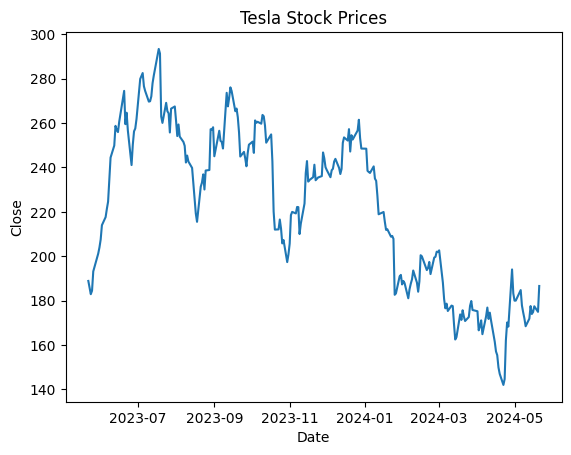

In [ ]:
# Visualize the data
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Tesla Stock Prices')
plt.show()

In [ ]:
# reset the index
df.set_index('Date', inplace=True)

##Decomposition Plot

In [ ]:
#Resampling data dan menjadikan waktunya sebagai data harian
df = df.resample('D').sum()

In [ ]:
df.shape

(366, 1)

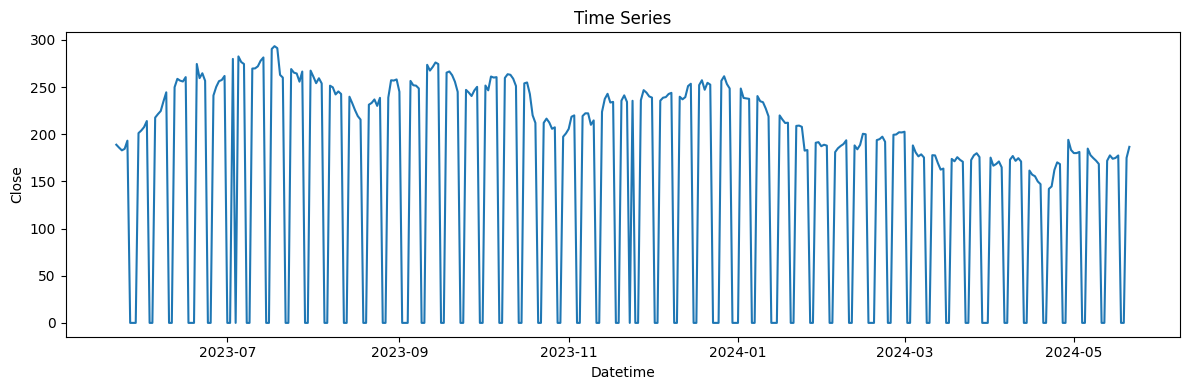

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.title('Time Series')
plt.tight_layout()
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df)

<Axes: title={'center': 'error'}, xlabel='Date'>

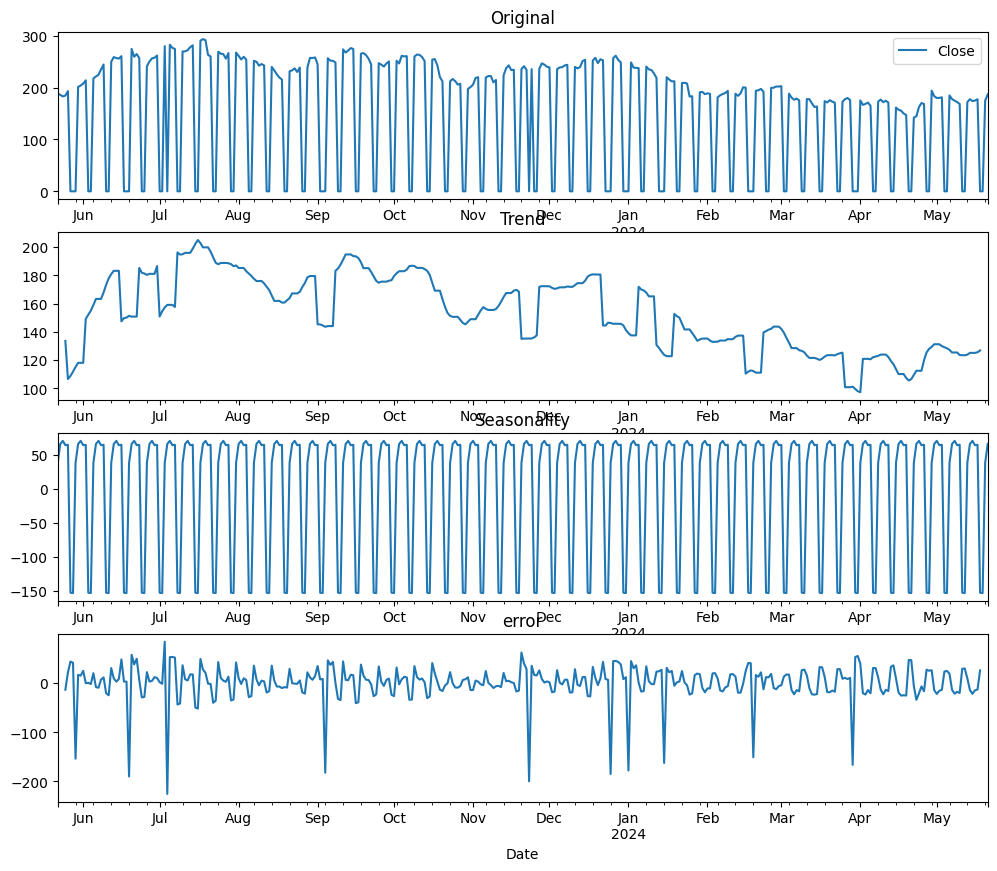

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
df.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='error', ax=axes[3])

##Normalisasi Data



In [ ]:
# Tampilkan data awal
print("Data Awal:")
print(df.head())

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi kolom 'Close'
df['Close'] = scaler.fit_transform(df[['Close']])
train_size = int(len(df) * 0.8) #split data
train, test = df['Close'][:train_size], df['Close'][train_size:]


# Tampilkan data yang telah dinormalisasi
print("\nData Setelah Normalisasi:")
print(df.head())

Data Awal:
                 Close
Date                  
2023-05-22  188.869995
2023-05-23  185.770004
2023-05-24  182.899994
2023-05-25  184.470001
2023-05-26  193.169998

Data Setelah Normalisasi:
               Close
Date                
2023-05-22  0.643860
2023-05-23  0.633292
2023-05-24  0.623509
2023-05-25  0.628861
2023-05-26  0.658519


##Modelling

###ETS models: Holt Winter's Seasonal Method

In [ ]:
# Definisi parameter untuk grid search
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = [7, 12, 30]

best_mse = float("inf")
best_params = {}

# Grid Search
for trend, seasonal, seasonal_period in product(trend_options, seasonal_options, seasonal_periods):
    try:
        ep = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
        fit = ep.fit()
        y_pred = fit.forecast(len(test))
        mse = mean_squared_error(test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': seasonal_period}
    except Exception as e:

        continue

# Memastikan bahwa parameter terbaik ditemukan
if not best_params:
    raise ValueError("Tidak ada kombinasi parameter yang menghasilkan model yang valid.")

# Menggunakan parameter terbaik untuk melatih model
best_model = ExponentialSmoothing(train, **best_params)
best_fit = best_model.fit()

# Memprediksi dengan model terbaik
y_pred = best_fit.forecast(len(test))

# Menyusun DataFrame untuk prediksi
pred_df = pd.DataFrame(y_pred, index=test.index, columns=['Predicted'])

# Menggabungkan DataFrame asli dengan DataFrame prediksi
combined_df = pd.concat([df, pred_df], axis=1)

# Mengevaluasi model
ep_mse = mean_squared_error(test, y_pred)
ep_rmse = np.sqrt(ep_mse)
ep_mae = mean_absolute_error(test, y_pred)

# Menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Menghindari pembagian dengan nol
    nonzero_mask = y_true != 0
    y_true = y_true[nonzero_mask]
    y_pred = y_pred[nonzero_mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ep_mape = mean_absolute_percentage_error(test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'RMSE: {ep_rmse}')
print(f'MAE: {ep_mae}')
print(f'MAPE: {ep_mape}')


Best Parameters: {'trend': None, 'seasonal': 'add', 'seasonal_periods': 7}
RMSE: 0.12875118903697344
MAE: 0.1031988407338261
MAPE: 15.751536553752906


In [ ]:
ep = ExponentialSmoothing(train, seasonal_periods=7, trend=None, seasonal='add').fit()

In [ ]:
ep.summary()

Dep. Variable:,Close,No. Observations:,292
Model:,ExponentialSmoothing,SSE,6.236
Optimized:,True,AIC,-1105.133
Trend:,None,BIC,-1072.042
Seasonal:,Additive,AICC,-1104.190
Seasonal Periods:,7,Date:,"Fri, 05 Jul 2024"
Box-Cox:,False,Time:,18:52:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0691200,alpha,True
smoothing_seasonal,0.000000,gamma,True


In [ ]:
ep

In [ ]:
ep_pred = ep.forecast(len(test))


In [ ]:
ep_rmse =  mean_squared_error(test, ep_pred, squared=False)
ep_rmse

0.12875118903697344

In [ ]:
ep_mae = mean_absolute_error(test, ep_pred)
ep_mae

0.1031988407338261

In [ ]:
# function to plot the forecast

def plot_forecast(forecast, model):
    plt.figure(figsize=(12,4))
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Close')
    plt.title(f'{model}')
    plt.legend()
    plt.tight_layout()
    plt.show()

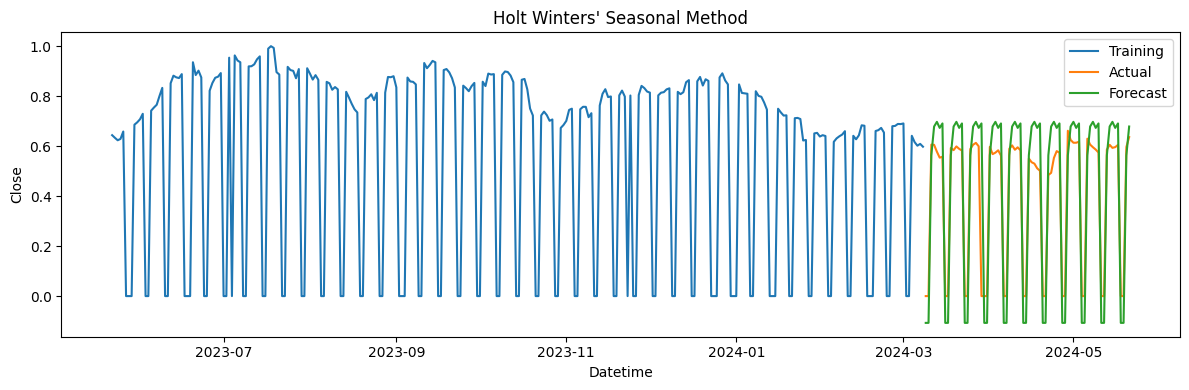

In [ ]:
plot_forecast(ep_pred, "Holt Winters' Seasonal Method")

###ARIMA Models : Seasonal ARIMA
karena deret waktu memiliki musiman dan tren, saya akan menggunakan ARIMA yang disempurnakan, SARIMA yang memperhitungkan bagian musiman dari ds. Sekarang, untuk melihat lebih dalam pada deret waktu yang ada, saya akan menggunakan plot ACF.

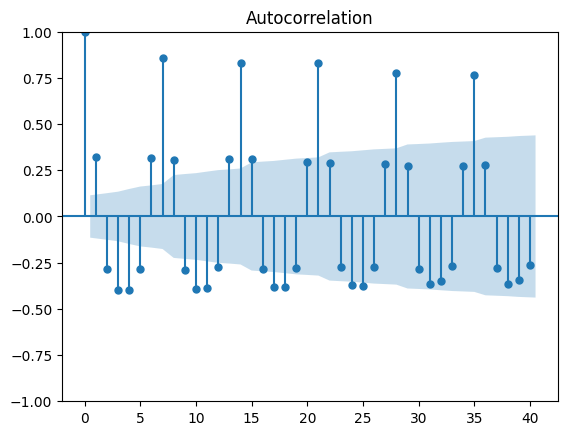

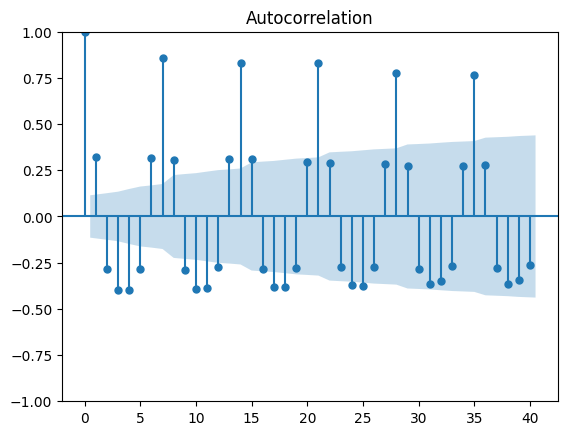

In [ ]:
plot_acf(train.squeeze(), lags=40)

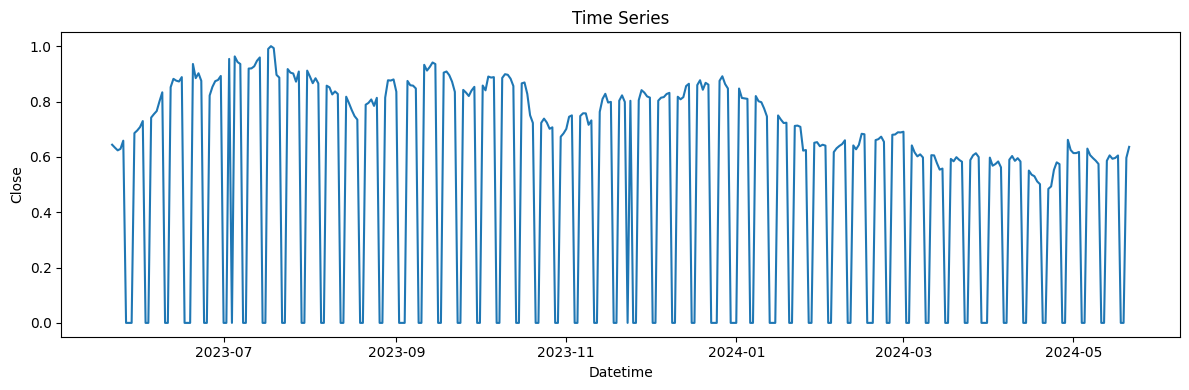

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.title('Time Series')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

# Definisi parameter untuk grid search
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
seasonal_period = 7  # Musiman mingguan
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(product(P, D, Q))]

# Grid Search untuk SARIMA
best_aic = float("inf")
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            sarima = SARIMAX(train,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = sarima.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

print(f'Best SARIMA{best_order}x{best_seasonal_order} AIC={best_aic}')

Best SARIMA(1, 0, 1)x(1, 0, 1, 7) AIC=-261.97133633129937


In [ ]:
# Cross-validation dengan TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []


for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Melatih model SARIMA dengan parameter terbaik
    sarima = SARIMAX(train['Close'],
                    order=best_order,
                    seasonal_order=best_seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fit = sarima.fit(disp=False)

    # Memprediksi
    y_pred = fit.forecast(steps=len(test))

    # Menghitung RMSE
    sarima_rmse = np.sqrt(mean_squared_error(test['Close'], y_pred))
    rmse_scores.append(sarima_rmse)

    # Menghitung MAE
    sarima_mae = mean_absolute_error(test['Close'], y_pred)

    # Menghitung MAPE
    sarima_mape = mean_absolute_percentage_error(test['Close'], y_pred)

# Menampilkan rata-rata RMSE dari cross-validation
print("RMSE:", sarima_rmse)
print("MAE:", sarima_mae)
print("MAPE:", sarima_mape)

RMSE: 0.10117946202471337
MAE: 0.05276468758201712
MAPE: 10.007653654716227


In [ ]:
sarima = SARIMAX(train['Close'], order=(0,0,0), seasonal_order=(1,0,1,7))

In [ ]:
fit = sarima.fit()

In [ ]:
print(fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     Close   No. Observations:                  305
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood                 130.201
Date:                   Fri, 05 Jul 2024   AIC                           -254.401
Time:                           18:53:13   BIC                           -243.240
Sample:                       05-22-2023   HQIC                          -249.937
                            - 03-21-2024                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9983      0.002    590.650      0.000       0.995       1.002
ma.S.L7       -0.7765      0.023    -33.191      0.000      -0.822      -0.731
sigma2         0.0229      0

In [ ]:
sarima = SARIMAX(test['Close'], order=(0,0,0), seasonal_order=(1,0,1,7))

In [ ]:
sarima_pred = sarima.fit().predict()

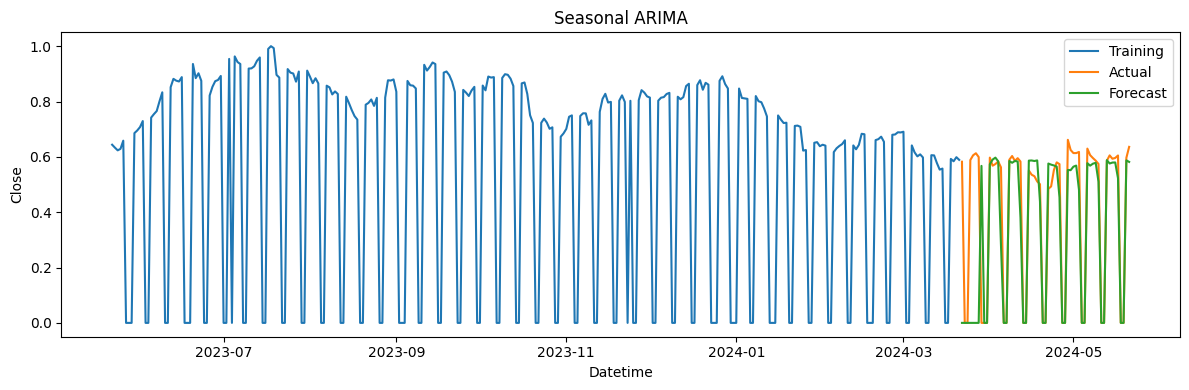

In [ ]:
plot_forecast(sarima_pred, "Seasonal ARIMA")

##Perbandingan Model

In [ ]:
rmse = [ep_rmse, sarima_rmse]
mae = [ep_mae, sarima_mae]
# mape = [ep_mape, sarima_mape]
models = ["Exp Smoothing", "SARIMA"]

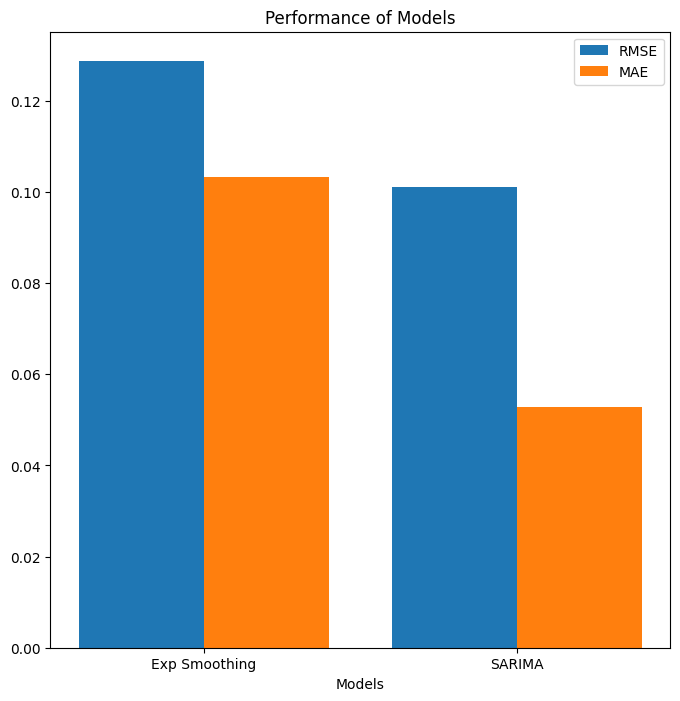

In [ ]:
X_axis = np.arange(len(models))
plt.figure(figsize=(8, 8))
plt.bar(X_axis - 0.2, rmse , 0.4, label = 'RMSE')
plt.bar(X_axis + 0.2, mae, 0.4, label = 'MAE')

plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.title("Performance of Models")
plt.legend()


##Pemilihan Model Forecasting

In [ ]:
# Denormalisasi kolom 'Close'
df['Close'] = scaler.inverse_transform(df[['Close']])
df

,Close
Date,
2023-05-22,188.869995
2023-05-23,185.770004
2023-05-24,182.899994
2023-05-25,184.470001
2023-05-26,193.169998
...,...
2024-05-17,177.460007
2024-05-18,0.000000
2024-05-19,0.000000


In [ ]:
#Menggunakan model SARIMA karena perbandingan kedua model SARIMA memiliki nilai error yang lebih kecil
sarima = SARIMAX(df['Close'], order=(0,0,0), seasonal_order=(1,0,1,7))

In [ ]:
fit = sarima.fit()

In [ ]:
# Forecasting 30 hari ke depan
forecast_steps = 30
forecast = fit.get_forecast(steps=forecast_steps)
forecast

In [ ]:
forecast_mean = forecast.predicted_mean

# Membuat DataFrame untuk hasil forecast
forecast = pd.DataFrame(forecast_mean, columns=['forecast'])

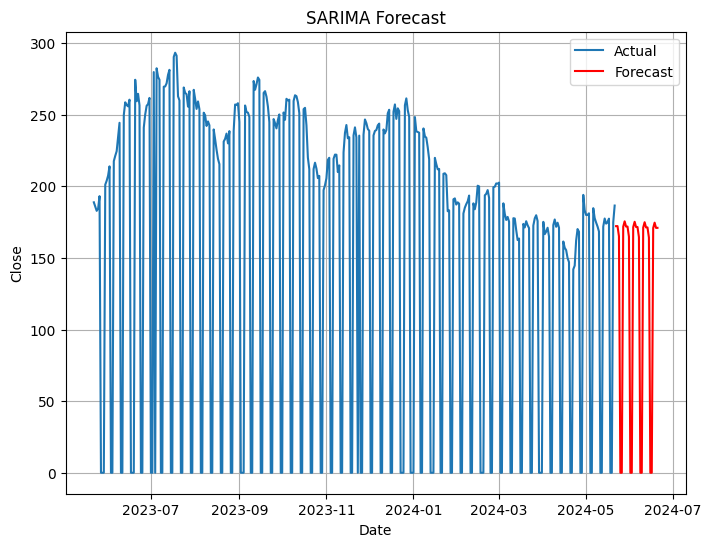

In [ ]:
# Plot hasil forecast
plt.figure(figsize=(8, 6))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(forecast_mean.index, forecast_mean.values, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()